# Quantum Time Series Analysis: Sliding Window Serial Model
Compatible with Qiskit 1.02+

### Authors
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.02 

### Aims
> *This script aims to create a variational quantum circuit to implement a forecast of a signal spectrum (derived from a continuous function with noise).*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html
- Brownlee, Jason. 
    *Introduction to Time Series Forecasting with Python How to Prepare Data and Develop Models to Predict the Future.*
    Machine Learning Mastery, 2020.<br/>
    https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/.
- About observables See:<br />
    https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
sys.path

['/home/jacob/miniconda3/envs/qiskit100/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/site-packages',
 '.',
 '..',
 '../..',
 '../../..']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
import warnings

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
# from utils.Callback import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
# from utils.Circuits import *
# from utils.Angles import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

In [3]:
### Libraries used in QTSA development

from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

In [4]:
### Listing control
debug = True
seed = 2022

### Software version
MAJOR = 8
MINOR = 9

### Constants
LOG_NAME = 'log_1'
CASE_NAME = 'sliding'
DATA_NAME = '2_sins'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_1',
 'sliding',
 '2_sins',
 'log_1/data',
 'log_1/training',
 'log_1/params',
 'log_1/analysis',
 'log_1/figures')

## Preare windowed version of data
*Values need to be in [0, 1] range*

### Training constants

In [5]:
### Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

### Data settings
samples_train = 50
samples_valid = 20
samples = samples_train+samples_valid
samples_hi_res = samples*2
train_pc = samples_train / samples
noise = 0

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 5
wind_step = 1
horizon = 1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()



TS noise = 0%, calculated noise in differenced TS = 0.0%, total noise = 0.0, over the points = 46



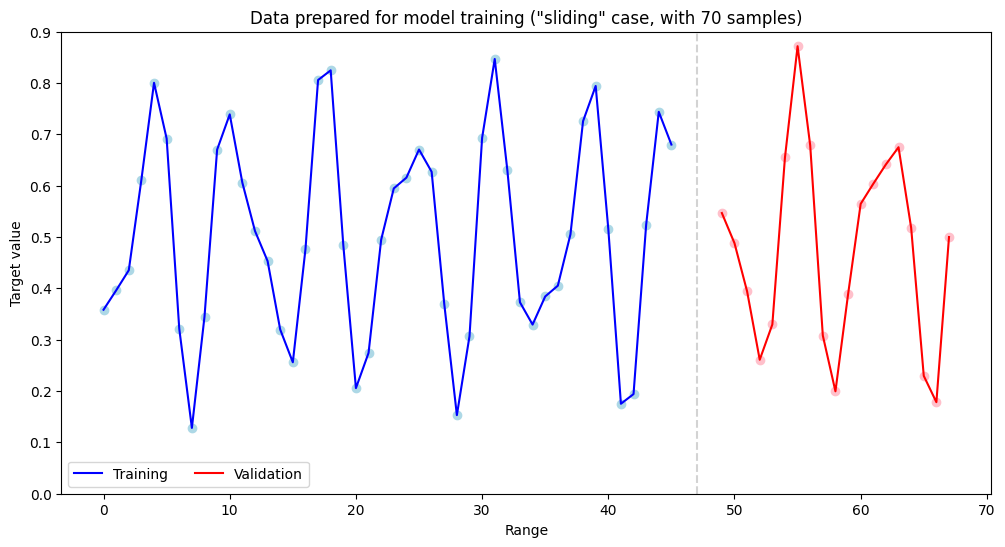

In [6]:
### Create the continuous pure data, (X_valid, y_valid) ignored
X_all, y_all, _, y_all_noisy, _, _ = \
    target_split(f, samples, noise=noise, train_pc=1.0)#, seed=seed)

### Plot target function and data
# plot_train_and_test_data(
#     X_all, y_all, X_all, y_all, [], [],
#     colors=['blue', 'lightblue', 'pink'], linestyles=['solid'], ylim=(0.05, 1),
#     title=f'Target function with pure data only ("{CASE_NAME}" case, with {samples} samples)',
#     save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_noise_org.eps')

# Prepare X and y for training
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = \
    Xy_wind_split(y_all, wind_size, wind_step, horizon, train_pc)

### Plot of training and validation data with noise
itg_integrated_plot(y_train_ts, y_valid_ts, y_train_ts, y_valid_ts, wind_step, noise,
     labels=['Training', 'Validation'], xlabel='Range', ylabel='Target value', ylim=(0, 0.9),
     title=f'Data prepared for model training ("{CASE_NAME}" case, with {samples} samples)',
     # line_styles={'train_pure':'solid', 'train_noisy':'none', 'valid_pure':'solid', 'valid_noisy':'none'},
     cols = {'train_pure':'blue', 'train_noisy':'lightblue', 'valid_pure':'red', 'valid_noisy':'pink'},
     marker_style='o', save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_noise_split.eps')
print()

In [7]:
from pprint import pprint

### Show a sample of data
print('\nSample of training examples (20 y values, X is ignored):\n')
pprint(y_all[0:20])
print('\nTS X train examples (5 records):\n')
pprint(X_train_ts[0:5,:])
print('\nTS y train examples (5 records):\n')
pprint(y_train_ts[0:5,:])
print('\nTS(X, y) train shape:', X_train_ts.shape, y_train_ts.shape)
print('TS(X, y) valid shape:', X_valid_ts.shape, y_valid_ts.shape, '\n')


Sample of training examples (20 y values, X is ignored):

array([0.5       , 0.82166007, 0.7704136 , 0.48181766, 0.32499393,
       0.35846391, 0.396177  , 0.43535716, 0.61185817, 0.80051322,
       0.69182409, 0.32134849, 0.1281973 , 0.34493183, 0.67024666,
       0.73899214, 0.60587504, 0.51189238, 0.45321367, 0.31980653])

TS X train examples (5 records):

array([[0.5       , 0.82166007, 0.7704136 , 0.48181766, 0.32499393],
       [0.82166007, 0.7704136 , 0.48181766, 0.32499393, 0.35846391],
       [0.7704136 , 0.48181766, 0.32499393, 0.35846391, 0.396177  ],
       [0.48181766, 0.32499393, 0.35846391, 0.396177  , 0.43535716],
       [0.32499393, 0.35846391, 0.396177  , 0.43535716, 0.61185817]])

TS y train examples (5 records):

array([[0.35846391],
       [0.396177  ],
       [0.43535716],
       [0.61185817],
       [0.80051322]])

TS(X, y) train shape: (46, 5) (46, 1)
TS(X, y) valid shape: (19, 5) (19, 1) 



# Classical MLP Solution (sklearn)

In [61]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.metrics import r2_score, mean_absolute_percentage_error 

### Produce the results with best max_iter
estimator = MLPRegressor(hidden_layer_sizes=(150,100,50), random_state=2022, max_iter=850, activation = 'relu',
                       solver = 'adam', shuffle=True)
estimator.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (150, 100, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 850,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 2022,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [62]:
### Train and score the model
regr = estimator.fit(X_train_ts, y_train_ts.reshape(y_train_ts.shape[0],))
yp_train_hat = regr.predict(X_train_ts)
yp_valid_hat = regr.predict(X_valid_ts)

# Score the model
train_r2 = regr.score(X_train_ts, y_train_ts); train_mae = mean_absolute_error(y_train_ts, yp_train_hat)
print('\nTraining   R2:\t', train_r2, '\nTraining   MAE:\t', train_mae)

valid_r2 = regr.score(X_valid_ts, y_valid_ts); valid_mae = mean_absolute_error(y_valid_ts, yp_valid_hat)
print('\nValidation R2:\t', valid_r2, '\nValidation MAE:\t', valid_mae, '\n')


Training   R2:	 0.9778573095882539 
Training   MAE:	 0.025664578427915755

Validation R2:	 0.965480156062597 
Validation MAE:	 0.03066298404556207 



In [63]:
def n_params(model):
    return (sum([a.size for a in model.coefs_]) +  
            sum([a.size for a in model.intercepts_]))
print(f'\nThe number of sklearn model parameters: {n_params(estimator)}\n')


The number of sklearn model parameters: 21101





TS noise = 0%, calculated noise in differenced TS = 3.12%, total noise = 1.1806, over the points = 46



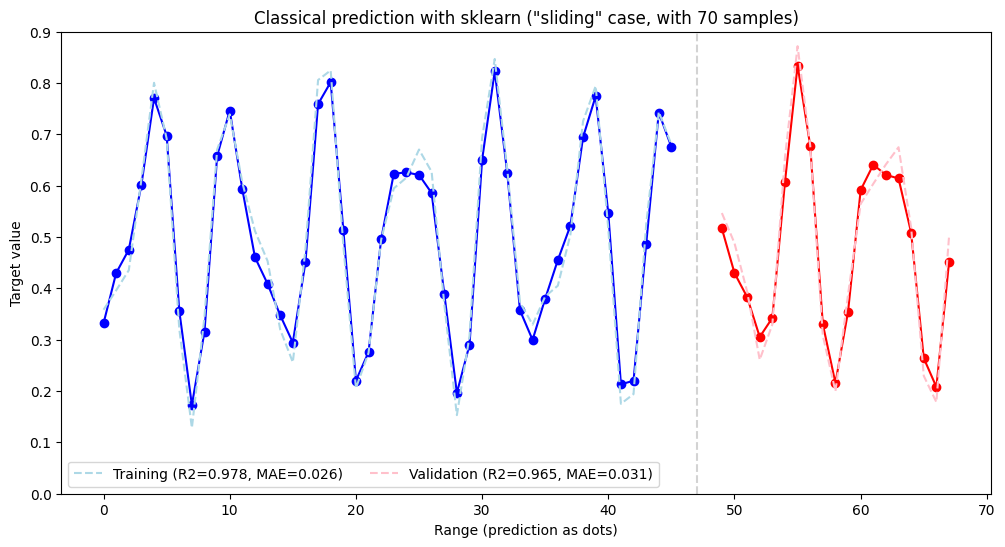

In [64]:
# Plot the data vs fit
itg_integrated_plot(y_train_ts, y_valid_ts, yp_train_hat.reshape(y_train_ts.shape), yp_valid_hat.reshape(y_valid_ts.shape), wind_step, 0,
     labels=[f'Training (R2={np.round(train_r2, 3)}, MAE={np.round(train_mae, 3)})', f'Validation (R2={np.round(valid_r2, 3)}, MAE={np.round(valid_mae, 3)})'], 
     xlabel='Range (prediction as dots)', ylabel='Target value', ylim=(0, 0.9),
     title=f'Classical prediction with sklearn ("{CASE_NAME}" case, with {samples} samples)',
     line_styles={'train_pure':'dashed', 'train_noisy':'solid', 'valid_pure':'dashed', 'valid_noisy':'solid'},
     cols = {'train_pure':'lightblue', 'train_noisy':'blue', 'valid_pure':'pink', 'valid_noisy':'red'},
     marker_style='o', save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_sklearn_pred.eps')

# Quantum MLP Solution (Qiskit) 

In [10]:
# from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
# from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
# from qiskit.utils import QuantumInstance, algorithm_globals
# from qiskit.circuit import Parameter
# from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, EfficientSU2, PauliFeatureMap
# from qiskit.algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
# from qiskit.compiler import transpile
# import qiskit.tools.jupyter

# from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
# from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

### Libraries used in QTSA development

from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

### Identify device

In [11]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

('CPU', 'GPU')

In [12]:
### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device

'CPU'

In [13]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

sampler.options

Options()

### Sliding window ansatz

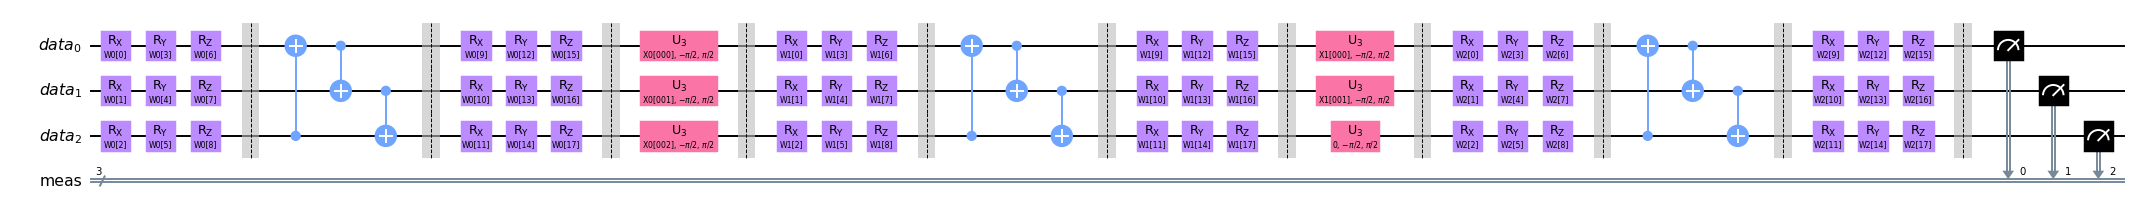

In [14]:
### Serial sliding window ansatz
#   - To be used with CircuitQNN / NeuralNetworkRegressor
#   qubit_no: The number of qubits in the circuit
#   input_no: The number of input values / the size of a sliding window
#   returns
#     Circuit: The serial sliding window ansatz 
#     SParams: The list of parameters used in all S blocks
#     WParams: The list of parameters used in all W blocks
#     Layers: The calculated number of W-S layers in the circuit

def swindow_serial_model(qubit_no, input_no, add_meas=False):
    
    sbl_layers = input_no // qubit_no + (0 if input_no % qubit_no == 0 else 1)
    used_sgates = 0

    qr = QuantumRegister(qubit_no, 'data')
    ansatz = QuantumCircuit(qr, name='ansatz')
    SParams = []
    WParams = []

    # Data-encoding circuit block, packs different input vars
    def SN(qubit_no, label):
        nonlocal used_sgates
        s_qr = QuantumRegister(qubit_no)
        s_ansatz = QuantumCircuit(s_qr, name='SSM')
        for q in range(qubit_no):
            # param_x = Parameter(label+'('+str(q)+')') if used_sgates < input_no else 0
            param_x = Parameter(f'{label}[{q:03d}]') if used_sgates < input_no else 0
            s_ansatz.rx(param_x, q)
            used_sgates += 1
        return s_ansatz

    # Trainable circuit block
    def W(qubit_no, label):
        w_qr = QuantumRegister(qubit_no)
        w_ansatz = QuantumCircuit(w_qr, name='W')
        w_ansatz.append(
            TwoLocal(qubit_no, ['rx', 'ry', 'rz'], 'cx', 
                     entanglement='circular',
                     reps=1, 
                     parameter_prefix=label, 
                     insert_barriers=True,
                     skip_final_rotation_layer=False),
            qargs=w_qr)
        return w_ansatz
    
    for l in range(sbl_layers):
        W1 = W(qubit_no, 'W'+str(l))
        WParams = WParams + W1.parameters[:]
        ansatz.append(W1, qargs=qr)
        ansatz.barrier()
        SX = SN(qubit_no, 'X'+str(l))
        SParams = SParams + SX.parameters[:]
        ansatz.append(SX, qargs=qr)
        ansatz.barrier()

    W1 = W(qubit_no, 'W'+str(sbl_layers))    
    WParams = WParams + W1.parameters[:]
    ansatz.append(W1, qargs=qr)

    if add_meas:
        ansatz.measure_all()

    return ansatz.decompose().decompose().decompose(), SParams, WParams, sbl_layers

# Test a sample serial ansatz
m, input_params, weight_params, layers_no = swindow_serial_model(3, 5, add_meas=True)

# print(f'Layers: {layers_no}\nParams: {m.parameters}\n')
# print('Input params:\n', input_params)
# print('\nWeight params:\n', weight_params)

print(){
display(m.draw(output='mpl', style='clifford', fold=False, scale=0.7))
print()

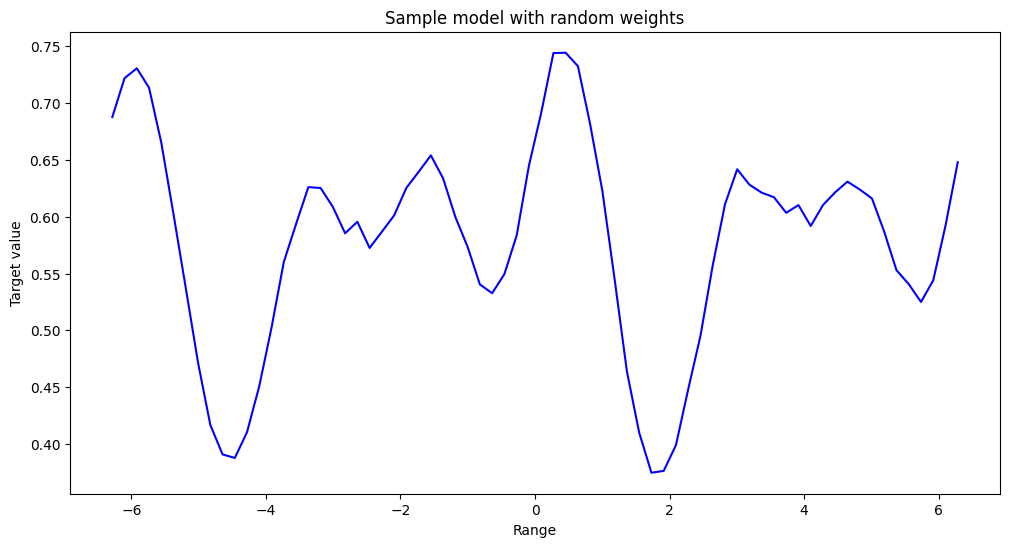

In [15]:
### Test the sliding window ansatz
#   - Note that when qubits=1 this will be identical to a serial model
#   - Without a random seed it will produce a different function every time

if debug:

    # Start the random process
    algorithm_globals.random_seed = seed
    np.random.seed(seed)

    # Define the ansatz architecture
    qubits = 3
    inputs = 5

    # Test model
    model, input_params, weight_params, layers_no = \
            swindow_serial_model(qubits, inputs, add_meas=True)
    
    # Define X and y vectors, each column is a rotation
    scol = 3
    y_vect = []
    x_matrix = np.zeros((inputs, samples))
    x_vect = np.linspace(-2*np.pi, 2*np.pi, samples)
    for c in range(inputs):
        rot_point = np.random.randint(samples)
        x_matrix[c] = np.array(list(x_vect)[rot_point:]+list(x_vect)[:rot_point])
    x_matrix = x_matrix.T

    # Initialise all parameters to random values (X is the last)
    param_vals = 2 * np.pi * np.random.random(model.num_parameters) # last block = True

    # Use ansatz to generate x, y pairs
    for x in x_matrix:
        
        # Create a circuit for each new value of x
        model, input_params, weight_params, layers_no = \
            swindow_serial_model(qubits, inputs, add_meas=True)
        for p in range(inputs):
            param_vals[-(p+1)] = x[p]
        # init_weights = param_vals[:-inputs]
        model_inst = model.assign_parameters(param_vals)

        # Generate y as expectation value of qubit measurements
        backend = Aer.get_backend('statevector_simulator') 
        result = sampler.run(model_inst, shots=shots).result()
        counts = result.quasi_dists[0]

        # Simulate "parity interpretation"
        # - Expectation value = counts of all circuit measurements with odd number of '1'
        exp_val = 0
        for k in counts.keys():
            res = [int(i) for i in bin(k)[2:]]
            exp_val += 0 if sum(res) % 2 == 0 else counts[k]
        y_vect.append(exp_val)

    # Plot the curve
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title("Sample model with random weights")
    plt.xlabel("Range")
    plt.ylabel("Target value")
    # plt.ylim(-0.1, 0.3)
    plt.plot(x_vect, y_vect, color='blue')
    plt.show()

### Construct a QNN inspired model

In [16]:
### Utility

def identity_interpret(x):
    return x

# Define our output
output_shape = 2
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2
identity_interpret = lambda x: x

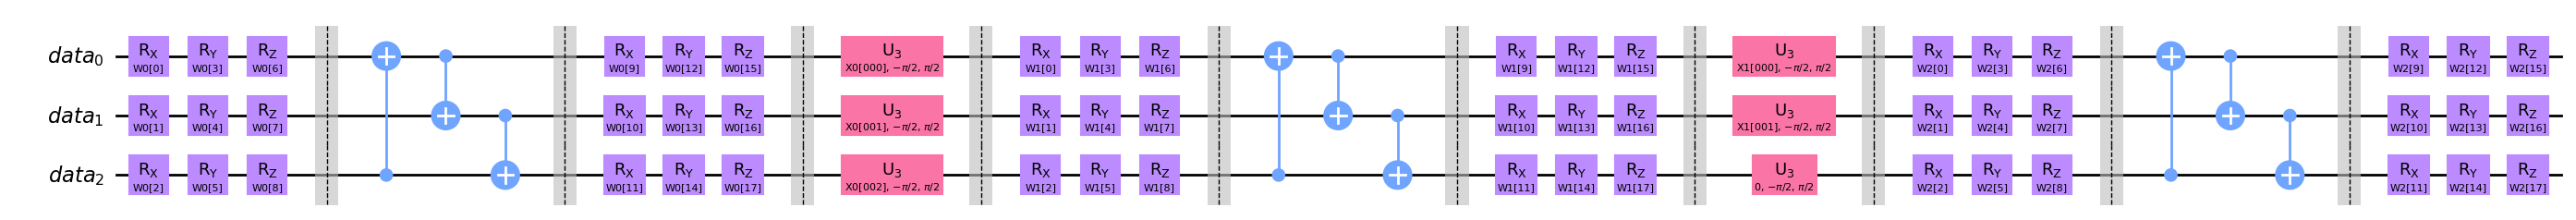

Model parameters: [ParameterVectorElement(W0[0]), ParameterVectorElement(W0[1]), ParameterVectorElement(W0[2]), ParameterVectorElement(W0[3]), ParameterVectorElement(W0[4]), ParameterVectorElement(W0[5]), ParameterVectorElement(W0[6]), ParameterVectorElement(W0[7]), ParameterVectorElement(W0[8]), ParameterVectorElement(W0[9]), ParameterVectorElement(W0[10]), ParameterVectorElement(W0[11]), ParameterVectorElement(W0[12]), ParameterVectorElement(W0[13]), ParameterVectorElement(W0[14]), ParameterVectorElement(W0[15]), ParameterVectorElement(W0[16]), ParameterVectorElement(W0[17]), ParameterVectorElement(W1[0]), ParameterVectorElement(W1[1]), ParameterVectorElement(W1[2]), ParameterVectorElement(W1[3]), ParameterVectorElement(W1[4]), ParameterVectorElement(W1[5]), ParameterVectorElement(W1[6]), ParameterVectorElement(W1[7]), ParameterVectorElement(W1[8]), ParameterVectorElement(W1[9]), ParameterVectorElement(W1[10]), ParameterVectorElement(W1[11]), ParameterVectorElement(W1[12]), Parameter

In [17]:
### Test

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Define model, its parameters and their initial values (including random input)
qubits = 3 # 1 # 2 # 3 # 4 # 5
inputs = X_train_ts.shape[1]
model, input_params, weight_params, layers_no = \
        swindow_serial_model(qubits, inputs)
init_weights = 2 * np.pi * algorithm_globals.random.random(model.num_parameters-inputs)

sample_qnn = SamplerQNN(
    circuit=model,
    input_params=model.parameters[-inputs:],
    weight_params=model.parameters[:-inputs],
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler
)

sample_data = X_train_ts

start = time.time()
probs = sample_qnn.forward(sample_data, init_weights)
elapsed = time.time() - start

display(model.draw(output='mpl', style='clifford', scale=1, fold=True))
print(f'Model parameters: {model.parameters[:-1]}\n')
print(f'Forward pass result for SamplerQNN:\n{probs[0:5]}.  \n\nShape: {probs.shape}, Time: {np.round(elapsed, 4)} secs')

### Create and train the model

In [18]:
### Define a regressor

print('Sliding window model built')

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Settings for sliding window model
qubits = 3 # 1 # 2 # 3 # 4 # 5
inputs = X_train_ts.shape[1]

model, input_params, weight_params, layers_no = \
        swindow_serial_model(qubits, inputs)
init_weights = 2 * np.pi * algorithm_globals.random.random(model.num_parameters-inputs)

# Construct QNN and show its circuit
regr_qnn = SamplerQNN(
    circuit=model,
    input_params=model.parameters[-inputs:],
    weight_params=model.parameters[:-inputs],
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler
)

print('Window size:', wind_size, ', Horizon=', horizon, ', Qubits=', qubits, ', Layers=', layers_no)

Sliding window model built
Window size: 5 , Horizon= 1 , Qubits= 3 , Layers= 2


In [19]:
### Define a regressor
algorithm_globals.random_seed = 2022
np.random.seed(seed)

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500) - very fast
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500) - slower
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16) - slowwweeer
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks
optimizer = L_BFGS_B(maxiter=30) # COBYLA(maxiter=500) # 
regr_callback = Regr_callback()
regr_callback.reset(obfun=[])

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss="squared_error",
    optimizer=optimizer, 
    initial_point=init_weights, 
    callback=regr_callback.graph
    # callback=regr_callback.collect
)

print('Regressor with', optimizer.setting.splitlines()[0])
print('Optimiser settings', optimizer.settings)

Regressor with Optimizer: L_BFGS_B
Optimiser settings {'maxfun': 15000, 'maxiter': 30, 'ftol': 2.220446049250313e-15, 'iprint': -1, 'eps': 1e-08, 'max_evals_grouped': 1, 'options': {}}


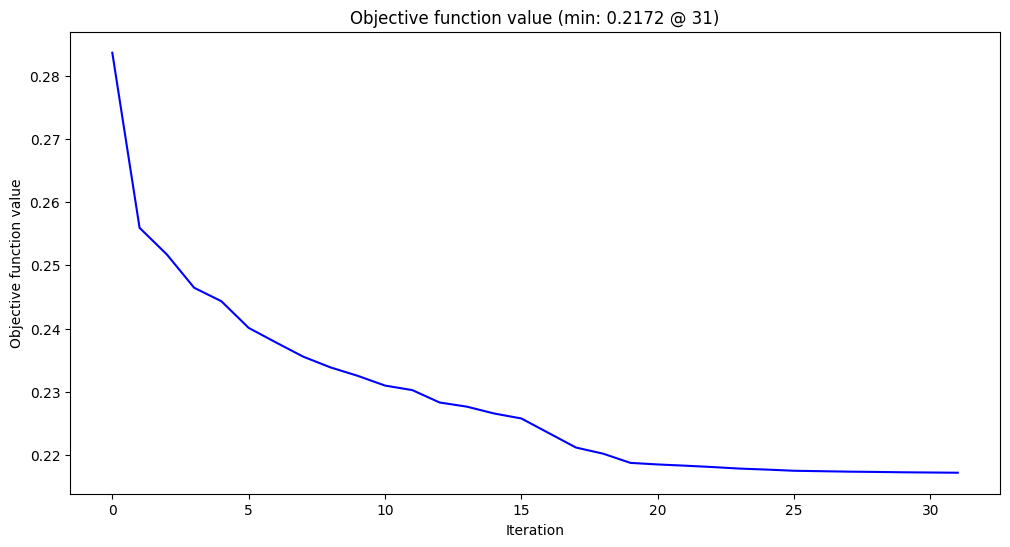

Optimum objective value: 0.2172 @ 31 (time=271.0 secs)


In [20]:
### Train the model

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Fit to data and plot progress
start = time.time()

# fit regressor
regressor.fit(X_train_ts, np.array([y[0] for y in y_train_ts]))
# regressor.fit(X_train_ts, y_train_ts) 
elapsed = time.time() - start
# regr_callback.plot()

### Find the optimum objective fun value and NN weights
min_obj = regr_callback.min_obj()
print(f'Optimum objective value: {np.round(min_obj[1], 4)} @ {min_obj[0]} (time={np.round(elapsed, 0)} secs)')


| Device | Optimizer | Min Cost @ Iter# | Time |
| :- | --- | :-: | -: |
| GPU | COBYLA(500)  | 0.23 @ 497 | 139.0 secs |
| CPU | COBYLA(500)  | 0.2266 @ 497 | 060.0 secs |
| CPU | L_BFGS_B(30) | 0.2172 @ 31  | 270.0 secs |

## Analysis and reporting

In [53]:
### Training parameters

### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   i: number of inputs
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
opt_name = optimizer.setting.splitlines()[0][11:]
epochs = optimizer.settings["maxiter"]
TRAIN_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{model.num_qubits}_i{inputs}_'+\
             f'{opt_name}_'+\
             f'ep{epochs}'
TRAIN_PREF

'sliding_n70_z0_q3_i5_L_BFGS_B_ep30'

### Score the model

In [68]:
### Calculate the score

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

yp_train = np.array([[1-yi[0], yi[0]] for yi in y_train_ts])
yp_train_true = np.array([yi[0] for yi in y_train_ts])
yp_train_hat = np.array([y1 for y0, y1 in regressor.predict(X_train_ts)])
yp_valid = np.array([[1-yi[0], yi[0]] for yi in y_valid_ts])
yp_valid_true = np.array([yi[0] for yi in y_valid_ts])
yp_valid_hat = np.array([y1 for y0, y1 in regressor.predict(X_valid_ts)])

train_r2 = regressor.score(X_train_ts, yp_train)
train_mae = mean_absolute_error(yp_train_true, yp_train_hat)
print('\nTraining   R2:\t', train_r2, '\nTraining   MAE:\t', train_mae)

valid_r2 = regressor.score(X_valid_ts, yp_valid)
valid_mae = mean_absolute_error(yp_valid_true, yp_valid_hat)
print('\nValidation R2:\t', valid_r2, '\nValidation MAE:\t', valid_mae, '\n')


Training   R2:	 0.6643753792319678 
Training   MAE:	 0.09999340913900863

Validation R2:	 0.6575189219818902 
Validation MAE:	 0.09920209712605887 



In [69]:
print(f'\nThe number of Qiskit model parameters: {regressor.neural_network.circuit.num_parameters}\n')


The number of Qiskit model parameters: 59



### Plot the results



TS noise = 0%, calculated noise in differenced TS = 11.61%, total noise = 4.5997, over the points = 46



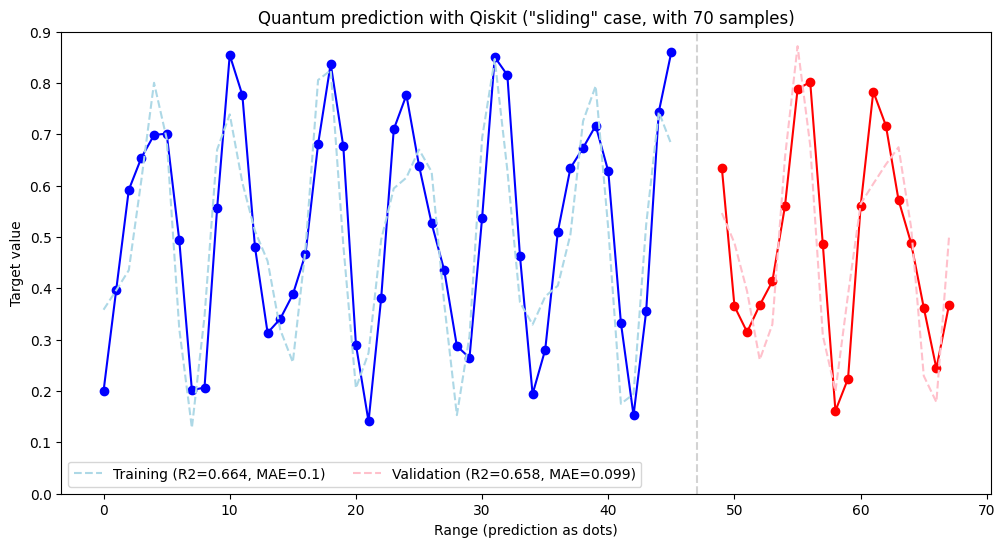

In [70]:
# Plot the data vs fit
itg_integrated_plot(y_train_ts, y_valid_ts, yp_train_hat.reshape(y_train_ts.shape), yp_valid_hat.reshape(y_valid_ts.shape), wind_step, 0,
     labels=[f'Training (R2={np.round(train_r2, 3)}, MAE={np.round(train_mae, 3)})', f'Validation (R2={np.round(valid_r2, 3)}, MAE={np.round(valid_mae, 3)})'], 
     xlabel='Range (prediction as dots)', ylabel='Target value', ylim=(0, 0.9),
     title=f'Quantum prediction with Qiskit ("{CASE_NAME}" case, with {samples} samples)',
     line_styles={'train_pure':'dashed', 'train_noisy':'solid', 'valid_pure':'dashed', 'valid_noisy':'solid'},
     cols = {'train_pure':'lightblue', 'train_noisy':'blue', 'valid_pure':'pink', 'valid_noisy':'red'},
     marker_style='o', save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_qiskit_pred.eps')

## Save training data

In [57]:
### Training info files 
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist{epochs}.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}_params.arr'
hist_chart_fpath = f'{FIGURES_PATH}/{TRAIN_PREF}_hist{epochs}.eps'
train_info_fpath

'log_1/training/sliding_n70_z0_q3_i5_L_BFGS_B_ep30_info.json'

In [58]:
## Save training parameters
### Save info details
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_sample':samples,
     'data_split':train_pc,
     'data_noise':noise,
     'ansatz_qubits':model.num_qubits,
     'ansatz_inputs':inputs,
     'log_interv':1,
     'opt_name':opt_name,
     'epochs':epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "log_1/training/sliding_n70_z0_q3_i5_L_BFGS_B_ep30_info.json":

	info[case_name] = sliding
	info[major_version] = 8
	info[minor_version] = 9
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0
	info[ansatz_qubits] = 3
	info[ansatz_inputs] = 5
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 30
	info[shots] = 10000
	info[seed] = 2022



In [59]:
### Save the history file, init and training parameters
write_ts_file(init_fpath, init_weights)
write_ts_file(history_fpath, regr_callback.objfun_vals)
write_ts_file(params_fpath, regr_callback.params_vals)

## System

In [27]:
!pip list | grep -e qiskit -e torch

qiskit                        1.0.2
qiskit-aer-gpu                0.14.1
qiskit-algorithms             0.3.0
qiskit-finance                0.4.1
qiskit-machine-learning       0.7.2
qiskit-nature                 0.7.2
qiskit-optimization           0.6.1
qiskit-qasm3-import           0.4.2
torch                         2.3.0
torchaudio                    2.3.0
torchsummary                  1.5.1
torchvision                   0.18.0
